In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import glob
import matplotlib.pyplot as plt

from IPython.display import *
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML

!mkdir test_videos_output

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mkdir: test_videos_output: File exists


In [2]:
dist_pickle = pickle.load(open('dist.p', 'rb'))
dist = dist_pickle['dist']
mtx = dist_pickle['mtx']

def show(img):
    if len(img.shape) > 2:
        img = img[:,:,::-1]
    cv2.imwrite('test.jpg', img)
    display(Image('test.jpg'))

class Smooth:
    def __init__(self, windowsize=24):
        self.window_size = windowsize
        self.data = np.zeros((self.window_size,), dtype=np.float32)
        self.index = 0
    
    def __iadd__(self, x):
        if self.index == 0:
            self.data[:] = x
        self.data[self.index % self.window_size] = x
        self.index += 1
        return self

    def __float__(self):
        return float(self.data.mean())

In [3]:
def process_image(image):
    global img, r, d, first, leftx, lefty, rightx, righty, left_fit, right_fit
    img = image.copy()
    # 校正图像
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # 手动计算变换矩阵
    img_size = (image.shape[1], image.shape[0])
    fy = image.shape[0]/720.0
    fx = image.shape[1]/1280.0
    
    src = np.array(
    [[583*fx, 450*fy],
     [204*fx, 720*fy],
     [1106*fx, 720*fy],
     [700*fx, 450*fy]], np.float32)

    dst = np.array(
        [[320*fx, 0*fy],
         [320*fx, 720*fy],
         [960*fx, 720*fy],
         [960*fx, 0*fy]], np.float32)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # 仿射变换为俯视图
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_NEAREST)

    # 提取道路线（黄+白）
    hsv = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (10, 80, 128), (25, 255, 255))
    white = cv2.inRange(hsv, (0, 0, 192), (255, 32, 255))
    yellow_white = cv2.bitwise_or(yellow, white)
    ret, bw = cv2.threshold(yellow_white, 127, 255, cv2.THRESH_BINARY)
    
    if first == True:
        # 从直方图寻找左右起始点
        histogram = np.sum(bw[bw.shape[0]//2:,:], axis=0)/255
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # 滑窗参数
        nwindows = 9
        window_height = np.int(bw.shape[0]/nwindows)

        nonzero = bw.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx_current = leftx_base
        rightx_current = rightx_base
        margin = 100
        minpix = 50
        left_lane_inds = []
        right_lane_inds = []

        # 滑窗搜索道路线
        for window in range(nwindows):
            win_y_low = bw.shape[0] - (window+1)*window_height
            win_y_high = bw.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        # It's now much easier to find line pixels!
        nonzero = bw.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin)))

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # 拟合曲线
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # 计算曲率半径
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(lefty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5
                    ) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5
                     ) / np.absolute(2*right_fit_cr[0])

    # 计算中心距离
    distance_of_center = (right_fit[-1] - left_fit[-1]) - 640
    distance_of_center *= xm_per_pix
    
    # 绘制道路面
    ploty = np.linspace(0, bw.shape[0]-1, bw.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    color_warp = np.zeros_like(warped).astype(np.uint8)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, pts.astype(int), (0,255, 0))

    # 绘制道路线
    color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # 仿射变换回来
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # 合并原图和绘制的结果
    mask = (cv2.cvtColor(newwarp, cv2.COLOR_BGR2GRAY) > 0).astype(np.uint8)
    result = cv2.addWeighted(undist, 0.7, newwarp, 0.5, 0)
    result_mask = cv2.bitwise_or(result, result, mask=mask)
    mask = 1 - mask
    undist_mask = cv2.bitwise_or(undist, undist, mask=mask)
    result = cv2.bitwise_or(undist_mask, result_mask)
    
    # 绘制半径
    r += (left_curverad + right_curverad)/2
    msg = 'Radius of Curvature = %.2fm' % min(float(r), 5000)
    cv2.putText(result, msg, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
    
    # 绘制中心距离
    d += distance_of_center
    if float(d) < 0:
        msg = 'Vehical is %.2fm left of center.' % d
    else:
        msg = 'Vehical is %.2fm right of center.' % d
    cv2.putText(result, msg, (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
    
    first = False
    return result

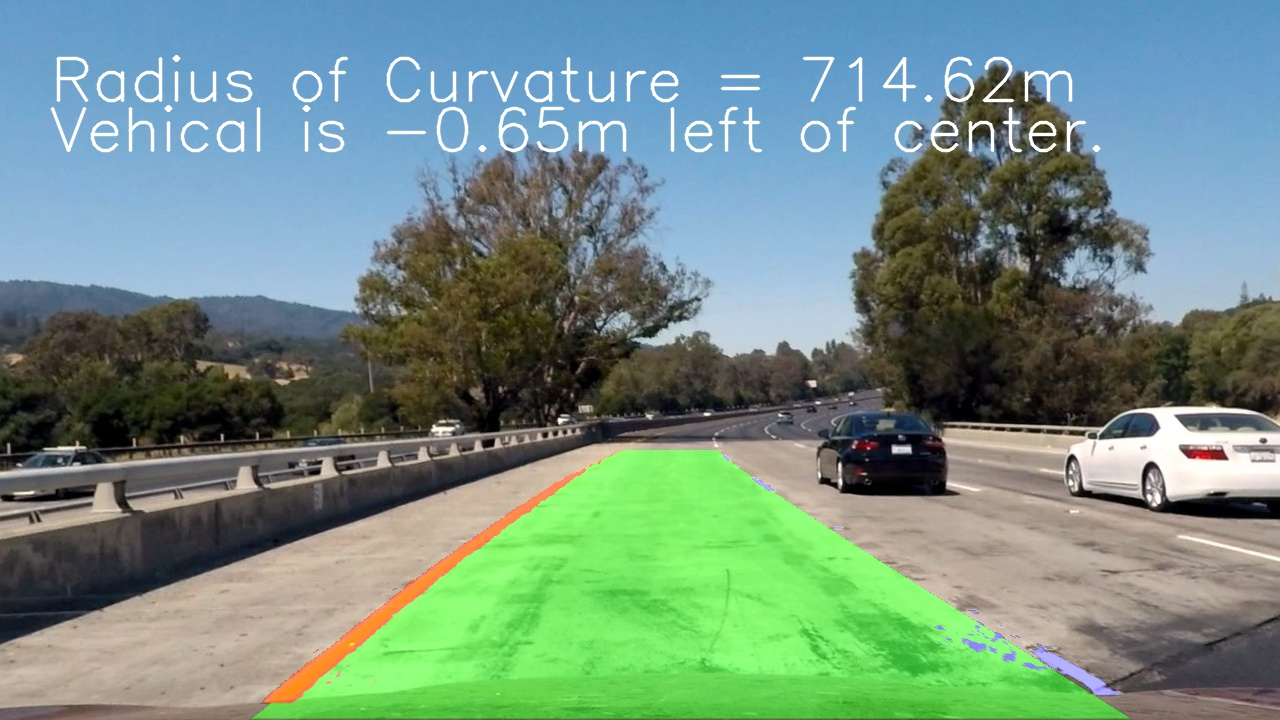

In [4]:
r = Smooth()
d = Smooth()
first = True

show(process_image(cv2.imread('test_images/test1.jpg')[:,:,::-1]))

In [5]:
video_filename = 'project_video.mp4'

file_output = 'test_videos_output/%s' % video_filename

smooth_window = 24
r = Smooth(smooth_window)
d = Smooth(smooth_window)
first = True

clip1 = VideoFileClip(video_filename) #.subclip(10, 15)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(file_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [01:32<00:00, 13.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 2min 10s, sys: 11.4 s, total: 2min 21s
Wall time: 1min 33s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(file_output))